1. Learn a multivariate Gaussian and generate samples

2. **Learn VAE and generate samples**

      a. train Model A. VAE with Conv2d, ConvTranspose2d, kernel_size=4, stride=2, latent_dims = 2

      b. train Model B. Find a model that yields the “checkerboard artifacts”

      c. train Model C. VAE with Conv2d, ConvTranspose2d, kernel_size=3, stride=2, latent_dims = 10

      d. compare Model A, B, C

      e. Interpolation in Latent Space

          - Interpolate 0 and 9 in latent space. (Model A)
          - (quiz) run cell multiple times: “Interpolation in Latent Space”, explain why different results are obtained
          
      f. Sample Latent Vector from “Prior” (VAE as Generator) (Model A)

          - Compare the prior and the distribution of training data in the latent space
          - Sample Latent Vector from estimated Gaussian


Variational Autoencoders (VAEs)
======

The VAE implemented here uses the setup found in most VAE papers: a multivariate Normal distribution for the conditional distribution of the latent vectors given and input image ($q_{\phi}(z | x_i)$ in the slides) and a multivariate Bernoulli distribution for the conditional distribution of images given the latent vector ($p_{\theta}(x | z)$ in the slides). Using a Bernoulli distribution, the reconstruction loss (negative log likelihood of a data point in the output distribution) reduces to the pixel-wise binary cross-entropy. See the [original VAE paper](https://arxiv.org/pdf/1312.6114.pdf), Appendix C.1 for details.

In [ ]:
# install pytorch (http://pytorch.org/) if run from Google Colaboratory
#import sys
#if 'google.colab' in sys.modules and 'torch' not in sys.modules:
#    from os.path import exists
#    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
#    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
#    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
#    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#    !pip3 install https://download.pytorch.org/whl/{accelerator}/torch-1.1.0-{platform}-linux_x86_64.whl
#    !pip3 install https://download.pytorch.org/whl/{accelerator}/torchvision-0.3.0-{platform}-linux_x86_64.whl


In [ ]:
%matplotlib inline
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Hyperparameter Settings
-------------------


In [ ]:
# 2-d latent space, parameter count in same order of magnitude
# as in the original VAE paper (VAE paper has about 3x as many)
latent_dims = 2
num_epochs = 100
batch_size = 128  # size of minibatch # 각 iteration에서 처리할 data 수
capacity = 64
learning_rate = 1e-3
variational_beta = 1
use_gpu = True
savepath='vae_2d_100.pth'

# # 10-d latent space, for comparison with non-variational auto-encoder
# latent_dims = 10
# num_epochs = 100
# batch_size = 128
# capacity = 64
# learning_rate = 1e-3
# variational_beta = 1
# use_gpu = True
# savepath='vae_10d_100.pth'


# MNIST Data Loading
-------------------

MNIST images show digits from 0-9 in 28x28 grayscale images. We do not center them at 0, because we will be using a binary cross-entropy loss that treats pixel values as probabilities in [0,1]. We create both a training set and a test set.

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([  ## Image->FloatTensor로 변환  ## 0~1로 scaling
    transforms.ToTensor()
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # shuffle : randomly permute data 

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# batch 확인
first_batch = train_dataloader.__iter__().__next__()

print('{:15s} | {:<25s} | {}'.format('name', 'type', 'size'))
print('{:15s} | {:<25s} | {}'.format('Num of Batch', '', len(train_dataloader)))
print('{:15s} | {:<25s} | {}'.format('first_batch', str(type(first_batch)), len(first_batch)))
print('{:15s} | {:<25s} | {}'.format('first_batch[0]', str(type(first_batch[0])), first_batch[0].shape))
print('{:15s} | {:<25s} | {}'.format('first_batch[1]', str(type(first_batch[1])), first_batch[1].shape))


name            | type                      | size
Num of Batch    |                           | 469
first_batch     | <class 'list'>            | 2
first_batch[0]  | <class 'torch.Tensor'>    | torch.Size([128, 1, 28, 28])
first_batch[1]  | <class 'torch.Tensor'>    | torch.Size([128])


# VAE Loss

In [ ]:
def vae_loss(recon_x, x, mu, logvar):
    # recon_x is the probability of a multivariate Bernoulli distribution p.
    # -log(p(x)) is then the pixel-wise binary cross-entropy.
    # Averaging or not averaging the binary cross-entropy over all pixels here
    # is a subtle detail with big effect on training, since it changes the weight
    # we need to pick for the other loss term by several orders of magnitude.
    # Not averaging is the direct implementation of the negative log likelihood,
    # but averaging makes the weight of the other loss term independent of the image resolution.
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
    
    # KL-divergence between the prior distribution over latent vectors
    # (the one we are going to sample from when generating new images)
    # and the distribution estimated by the generator for the given image.
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + variational_beta * kldivergence
    

# VAE model Definition 

-----------------------
We use a convolutional encoder and decoder, which generally gives better performance than fully connected versions that have the same number of parameters.

In convolution layers, we increase the channels as we approach the bottleneck, but note that the total number of features still decreases, since the channels increase by a factor of 2 in each convolution, but the spatial size decreases by a factor of 4.

Kernel size 4 is used to avoid biasing problems described here: https://distill.pub/2016/deconv-checkerboard/

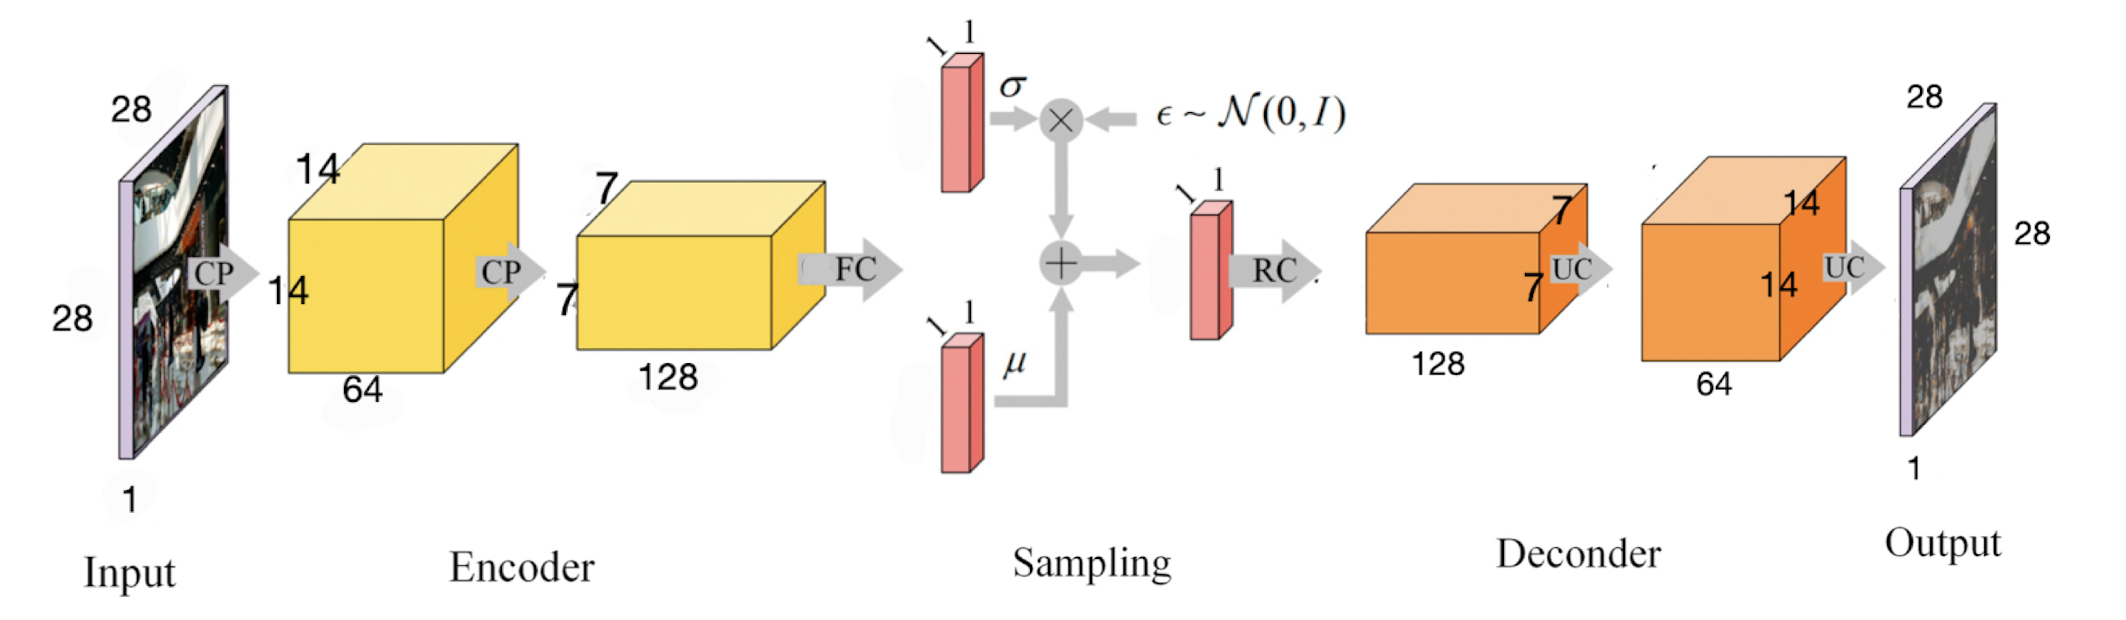

In [ ]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class UnFlatten(nn.Module):
    def forward(self, input, size=capacity):
        return input.view(input.size(0), size*2 , 7, 7)

## Model A

```
Conv2d, ConvTranspose2d, kernel_size=4, stride=2, latent_dims = 2 
```

`output size = {input_size  - filter_size  + (2 * padding)} / stride ]+1`

---

Define model A

In [ ]:
class vae_A(nn.Module):
    def __init__(self, c = capacity):
      super(vae_A, self).__init__()
      self.encoder = nn.Sequential(
          nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1), # [64, 14, 14]
          nn.ReLU(),
          nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1), # [128, 7, 7]
          nn.ReLU(),
          Flatten()
      )

      self.fc_mu = nn.Linear(in_features = (c*2)*7*7, out_features = latent_dims)
      self.fc_logvar = nn.Linear(in_features = (c*2)*7*7, out_features = latent_dims)
      self.fc_z = nn.Linear(in_features = latent_dims, out_features = (c*2)*7*7)

      self.decoder = nn.Sequential(
          nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1),
          nn.ReLU(),
          nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1),
          nn.Sigmoid()
      )

    ###############################################  
    def encode(self, x):
      x = self.encoder(x)
      x_mu, x_logvar = self.fc_mu(x), self.fc_logvar(x)
      return x_mu, x_logvar


    def decode(self, z):
      z = self.fc_z(z)
      z = z.view(z.size(0), capacity*2, 7, 7) # unflatten batch of feature vectors to 
                                              # a batch of multi-channel feature maps
      x_recon = self.decoder(z)
      return x_recon
      

    ###############################################  
    def latent_sample(self, mu, logvar):  #### 샘플링해주는 함수 
      if self.training:
          # the reparameterization trick
          std = logvar.mul(0.5).exp_()
          eps = torch.empty_like(std).normal_()
          return eps.mul(std).add_(mu)
      else:
          return mu

    ###############################################
    def forward(self, x): ### 실제 동작 
        latent_mu, latent_logvar = self.encode(x)
        latent = self.latent_sample(latent_mu, latent_logvar)  # 
        x_recon = self.decode(latent)
        return x_recon, latent_mu, latent_logvar



num_params = 308357

In [ ]:
vae_A = vae_A()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
vae_A = vae_A.to(device)

num_params = sum(p.numel() for p in vae_A.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 308357


In [ ]:
vae_A.parameters()

<generator object Module.parameters at 0x7f263dacec80>

## Model B

Find a model that yields the “checkerboard artifacts”

`stride = 2, size = 3`

Define model B

In [ ]:
class vae_B(nn.Module):
    def __init__(self, c = capacity, latent_dims=2 ):
      super(vae_B, self).__init__()
      self.encoder = nn.Sequential(
          nn.Conv2d(in_channels=1, out_channels=c, kernel_size=3, stride=2, padding=1), # [64, 14, 14]
          nn.ReLU(),
          nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=3, stride=2, padding=1), # [128, 7, 7]
          nn.ReLU(),
          Flatten()
      )

      self.fc_mu = nn.Linear(in_features = 2*c*7*7 , out_features = latent_dims)
      self.fc_logvar = nn.Linear(in_features = 2*c*7*7 , out_features = latent_dims)
      self.fc_z = nn.Linear(in_features = latent_dims, out_features = 2*c*7*7)

      self.decoder = nn.Sequential(
          UnFlatten(),
          nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=3, stride=2, padding=1, output_padding=1),
          nn.ReLU(),
          nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1),
          nn.Sigmoid()
      )

    ###############################################  
    def encode(self, x):
      x = self.encoder(x)
      x_mu, x_logvar = self.fc_mu(x), self.fc_logvar(x)
      return x_mu, x_logvar

    ###############################################  
    def latent_sample(self, mu, logvar):
      if self.training:
          # the reparameterization trick
          std = logvar.mul(0.5).exp_()
          eps = torch.empty_like(std).normal_()
          return eps.mul(std).add_(mu)
      else:
          return mu

    ###############################################
    def decode(self, z):
      z = self.fc_z(z)
      x_recon = self.decoder(z)
      return x_recon

    ###############################################
    def forward(self, x):
        latent_mu, latent_logvar = self.encode(x)
        latent = self.latent_sample(latent_mu, latent_logvar)  # 
        x_recon = self.decode(latent)
        return x_recon, latent_mu, latent_logvar


In [ ]:
PATH = "/content/drive/MyDrive/Colab Notebooks/DATA303/pretrained/"
filename = 'vae_B_2d_100.pth'


vae_B = vae_B()
vae_B.load_state_dict(torch.load(PATH+filename))

print('done')

done


num_params : 192773

In [ ]:
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
vae_B = vae_B.to(device)

num_params = sum(p.numel() for p in vae_B.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 192773


## Model C



```
Conv2d, ConvTranspose2d, kernel_size=3, stride=2, latent_dims = 10
```



Define model C

In [ ]:
class vae_C(nn.Module):
    def __init__(self, c = capacity, latent_dims=10 ):
      super(vae_C, self).__init__()
      self.encoder = nn.Sequential(
          nn.Conv2d(in_channels=1, out_channels=c, kernel_size=3, stride=2, padding=1), # [64, 14, 14]
          nn.ReLU(),
          nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=3, stride=2, padding=1), # [128, 7, 7]
          nn.ReLU(),
          Flatten()
      )

      self.fc_mu = nn.Linear(in_features = 2*c*7*7 , out_features = latent_dims)
      self.fc_logvar = nn.Linear(in_features = 2*c*7*7 , out_features = latent_dims)
      self.fc_z = nn.Linear(in_features = latent_dims, out_features = 2*c*7*7)

      self.decoder = nn.Sequential(
          UnFlatten(),
          nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=3, stride=2, padding=1, output_padding=1),
          nn.ReLU(),
          nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1),
          nn.Sigmoid()
      )

    ###############################################  

    def encode(self, x):
      x = self.encoder(x)
      x_mu, x_logvar = self.fc_mu(x), self.fc_logvar(x)
      return x_mu, x_logvar

    ###############################################  

    def latent_sample(self, mu, logvar):
      if self.training:
          # the reparameterization trick
          std = logvar.mul(0.5).exp_()
          eps = torch.empty_like(std).normal_()
          return eps.mul(std).add_(mu)
      else:
          return mu

    ###############################################
    def decode(self, z):
      z = self.fc_z(z)
      x_recon = self.decoder(z)
      return x_recon

    ###############################################
    def forward(self, x):
        latent_mu, latent_logvar = self.encode(x)
        latent = self.latent_sample(latent_mu, latent_logvar)  # 
        x_recon = self.decode(latent)
        return x_recon, latent_mu, latent_logvar


In [ ]:
# Load saved model
PATH = "/content/drive/MyDrive/Colab Notebooks/DATA303/pretrained/"
filename = 'vae_C_10d_100.pth'

vae_C = vae_C()
vae_C.load_state_dict(torch.load(PATH+filename))

print('done')

done


num_params : 343317

In [ ]:
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
vae_C = vae_C.to(device)

num_params = sum(p.numel() for p in vae_C.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 343317


# Train VAE + save model
--------

## Train : Model A

In [ ]:
optimizer = torch.optim.Adam(params=vae_A.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode
vae_A.train()

train_loss_avg_A = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg_A.append(0)
    num_batches = 0
    
    for image_batch, _ in train_dataloader:
        
        image_batch = image_batch.to(device)
        image_batch_recon, latent_mu, latent_logvar = vae_A(image_batch)         # vae reconstruction
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)        # reconstruction error
        optimizer.zero_grad()        # backpropagation
        loss.backward()        # backpropagation
        optimizer.step()         # one step of the optmizer (using the gradients from backpropagation)

        train_loss_avg_A[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg_A[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg_A[-1]))

Training ...
Epoch [1 / 100] average reconstruction error: 23286.158024
Epoch [2 / 100] average reconstruction error: 21000.320144
Epoch [3 / 100] average reconstruction error: 20449.285964
Epoch [4 / 100] average reconstruction error: 20162.577917
Epoch [5 / 100] average reconstruction error: 19959.147184
Epoch [6 / 100] average reconstruction error: 19825.573205
Epoch [7 / 100] average reconstruction error: 19703.926933
Epoch [8 / 100] average reconstruction error: 19615.061205
Epoch [9 / 100] average reconstruction error: 19530.679440
Epoch [10 / 100] average reconstruction error: 19474.421492
Epoch [11 / 100] average reconstruction error: 19404.908249
Epoch [12 / 100] average reconstruction error: 19364.849291
Epoch [13 / 100] average reconstruction error: 19323.111493
Epoch [14 / 100] average reconstruction error: 19272.063679
Epoch [15 / 100] average reconstruction error: 19231.740692
Epoch [16 / 100] average reconstruction error: 19203.427333
Epoch [17 / 100] average reconstruct

In [ ]:
torch.save(vae_A.state_dict(), '/content/drive/MyDrive/Colab Notebooks/DATA303/pretrained/vae_A_2d_100.pth')

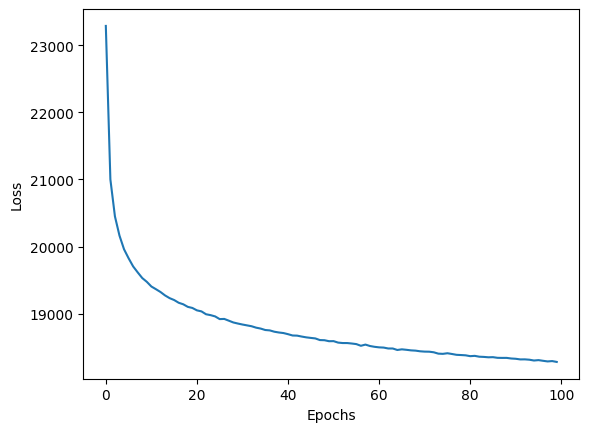

In [ ]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg_A)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## Train : Model B

In [ ]:
optimizer = torch.optim.Adam(params=vae_B.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode
vae_B.train()

train_loss_avg_B = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg_B.append(0)
    num_batches = 0
    
    for image_batch, _ in train_dataloader:
        
        image_batch = image_batch.to(device)
        image_batch_recon, latent_mu, latent_logvar = vae_B(image_batch)         # vae reconstruction
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)        # reconstruction error
        optimizer.zero_grad()        # backpropagation
        loss.backward()        # backpropagation
        optimizer.step()         # one step of the optmizer (using the gradients from backpropagation)

        train_loss_avg_B[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg_B[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg_B[-1]))

Training ...
Epoch [1 / 100] average reconstruction error: 24928.372797
Epoch [2 / 100] average reconstruction error: 22218.635536
Epoch [3 / 100] average reconstruction error: 21594.582773
Epoch [4 / 100] average reconstruction error: 21107.314287
Epoch [5 / 100] average reconstruction error: 20800.848462
Epoch [6 / 100] average reconstruction error: 20578.732874
Epoch [7 / 100] average reconstruction error: 20405.366211
Epoch [8 / 100] average reconstruction error: 20273.294562
Epoch [9 / 100] average reconstruction error: 20179.802001
Epoch [10 / 100] average reconstruction error: 20097.214517
Epoch [11 / 100] average reconstruction error: 20035.101696
Epoch [12 / 100] average reconstruction error: 19985.753969
Epoch [13 / 100] average reconstruction error: 19929.969366
Epoch [14 / 100] average reconstruction error: 19882.045255
Epoch [15 / 100] average reconstruction error: 19845.239997
Epoch [16 / 100] average reconstruction error: 19809.042325
Epoch [17 / 100] average reconstruct

In [ ]:
torch.save(vae_B.state_dict(), '/content/drive/MyDrive/Colab Notebooks/DATA303/pretrained/vae_B_2d_100.pth')

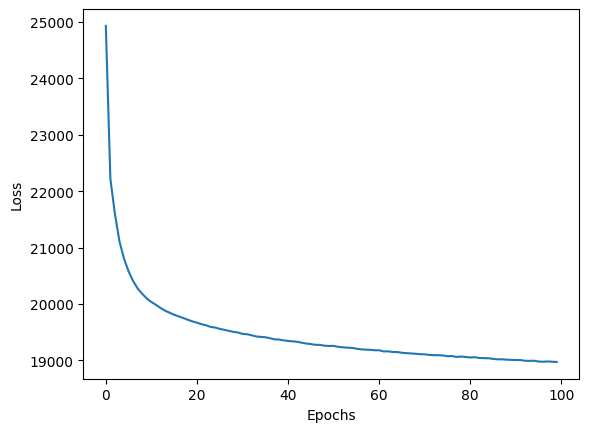

In [ ]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg_B)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## Train : Model C

In [ ]:
optimizer = torch.optim.Adam(params=vae_C.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode
vae_C.train()

train_loss_avg_C = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg_C.append(0)
    num_batches = 0
    
    for image_batch, _ in train_dataloader:
        image_batch = image_batch.to(device)
        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae_C(image_batch)
        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg_C[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg_C[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg_C[-1]))

Training ...
Epoch [1 / 100] average reconstruction error: 19176.069396
Epoch [2 / 100] average reconstruction error: 15402.415135
Epoch [3 / 100] average reconstruction error: 14745.374452
Epoch [4 / 100] average reconstruction error: 14427.595272
Epoch [5 / 100] average reconstruction error: 14208.661608
Epoch [6 / 100] average reconstruction error: 14060.312989
Epoch [7 / 100] average reconstruction error: 13933.422400
Epoch [8 / 100] average reconstruction error: 13837.440752
Epoch [9 / 100] average reconstruction error: 13758.312781
Epoch [10 / 100] average reconstruction error: 13688.212458
Epoch [11 / 100] average reconstruction error: 13635.139505
Epoch [12 / 100] average reconstruction error: 13587.774372
Epoch [13 / 100] average reconstruction error: 13544.239764
Epoch [14 / 100] average reconstruction error: 13506.552899
Epoch [15 / 100] average reconstruction error: 13470.996010
Epoch [16 / 100] average reconstruction error: 13440.201803
Epoch [17 / 100] average reconstruct

In [ ]:
torch.save(vae_C.state_dict(), '/content/drive/MyDrive/Colab Notebooks/DATA303/pretrained/vae_C_10d_100.pth')

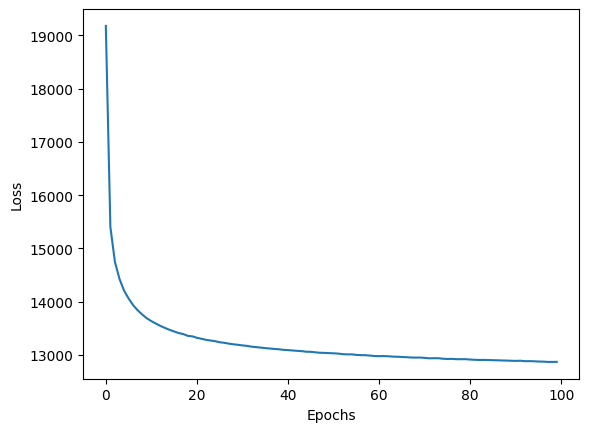

In [ ]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg_C)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Alternatively: Load Pre-Trained VAE
-----------------------------

In [ ]:
vae = vae_A()

In [ ]:
filename = 'vae_2d.pth'
# filename = 'vae_10d.pth'
import urllib
if not os.path.isdir('./pretrained'):
    os.makedirs('./pretrained')
print('downloading ...')
urllib.request.urlretrieve ("http://geometry.cs.ucl.ac.uk/creativeai/pretrained/"+filename, "./pretrained/"+filename)
vae.load_state_dict(torch.load('./pretrained/'+filename))
print('done')

# this is how the VAE parameters can be saved:
# torch.save(vae.state_dict(), './pretrained/my_vae.pth')

# Evaluate on the Test Set
-------------------------

In [ ]:
# Load saved model
PATH = "/content/drive/MyDrive/Colab Notebooks/DATA303/pretrained/"

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")


vae_A = vae_A()
vae_A.load_state_dict(torch.load(PATH+'vae_A_2d_100.pth'))
vae_A = vae_A.to(device)


vae_B = vae_B()
vae_B.load_state_dict(torch.load(PATH+'vae_B_2d_100.pth'))
vae_B = vae_B.to(device)


vae_C = vae_C()
vae_C.load_state_dict(torch.load(PATH+'vae_C_10d_100.pth'))
vae_C = vae_C.to(device)

print('done')

done


In [ ]:
# set to evaluation mode
vae_A.eval()
vae_B.eval()
vae_C.eval()

test_loss_avg_A, test_loss_avg_B, test_loss_avg_C = 0,0,0
num_batches = 0

for image_batch, _ in test_dataloader:
    with torch.no_grad():
        image_batch = image_batch.to(device)

        # vae reconstruction
        image_batch_recon_A, latent_mu_A, latent_logvar_A = vae_A(image_batch)
        image_batch_recon_B, latent_mu_B, latent_logvar_B = vae_B(image_batch)
        image_batch_recon_C, latent_mu_C, latent_logvar_C = vae_C(image_batch)

        # reconstruction error
        loss_A = vae_loss(image_batch_recon_A, image_batch, latent_mu_A, latent_logvar_A)
        loss_B = vae_loss(image_batch_recon_B, image_batch, latent_mu_B, latent_logvar_B)
        loss_C = vae_loss(image_batch_recon_C, image_batch, latent_mu_C, latent_logvar_C)

        test_loss_avg_A += loss_A.item()
        test_loss_avg_B += loss_B.item()
        test_loss_avg_C += loss_C.item()

        num_batches += 1
    
test_loss_avg_A /= num_batches
test_loss_avg_B /= num_batches
test_loss_avg_C /= num_batches

print('<model A> average reconstruction error: %f' % (test_loss_avg_A))
print('<model B> average reconstruction error: %f' % (test_loss_avg_B))
print('<model C> average reconstruction error: %f' % (test_loss_avg_C))

<model A> average reconstruction error: 19286.069954
<model B> average reconstruction error: 19385.847706
<model C> average reconstruction error: 12335.758690


# Visualization

## Visualize Reconstructions
--------------------------

define visualization module

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# Visualize all the generated images
from matplotlib.gridspec import GridSpec 

plt.ion()

import torchvision.utils
# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):
    with torch.no_grad():
        images = images.to(device)
        images, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

Visualize Reconstructions

Original images


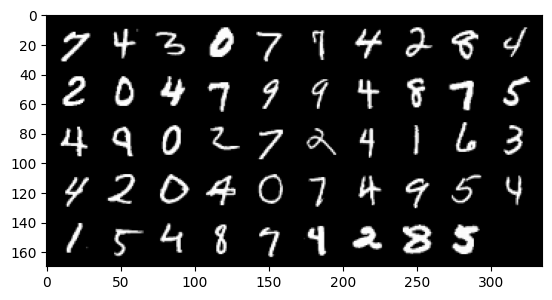

<model A> VAE reconstruction:


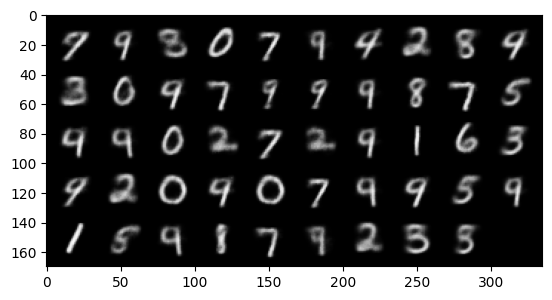

<model B> VAE reconstruction:


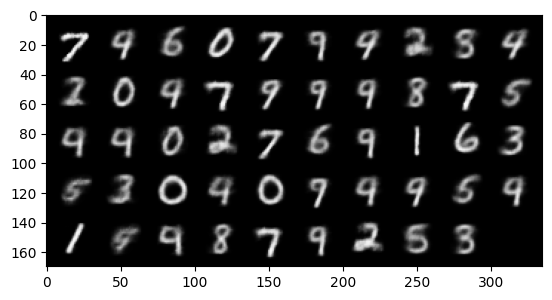

<model C> VAE reconstruction:


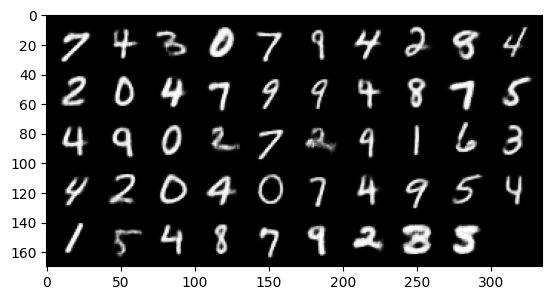

In [ ]:
#vae.eval()
images, labels = test_dataloader.__iter__().__next__()

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the vae
print('<model A> VAE reconstruction:')
visualise_output(images, vae_A)

print('<model B> VAE reconstruction:')
visualise_output(images, vae_B)

print('<model C> VAE reconstruction:')
visualise_output(images, vae_C)

# Interpolate in Latent Space (QUIZ)
----------------------------

In [ ]:
def interpolation(lambda1, model, img1, img2):
    
    with torch.no_grad():
        # latent vector of first image
        img1 = img1.to(device)
        latent_1, _ = model.encode(img1)

        # latent vector of second image
        img2 = img2.to(device)
        latent_2, _ = model.encode(img2)

        # interpolation of the two latent vectors
        inter_latent = lambda1* latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        inter_image = model.decode(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image

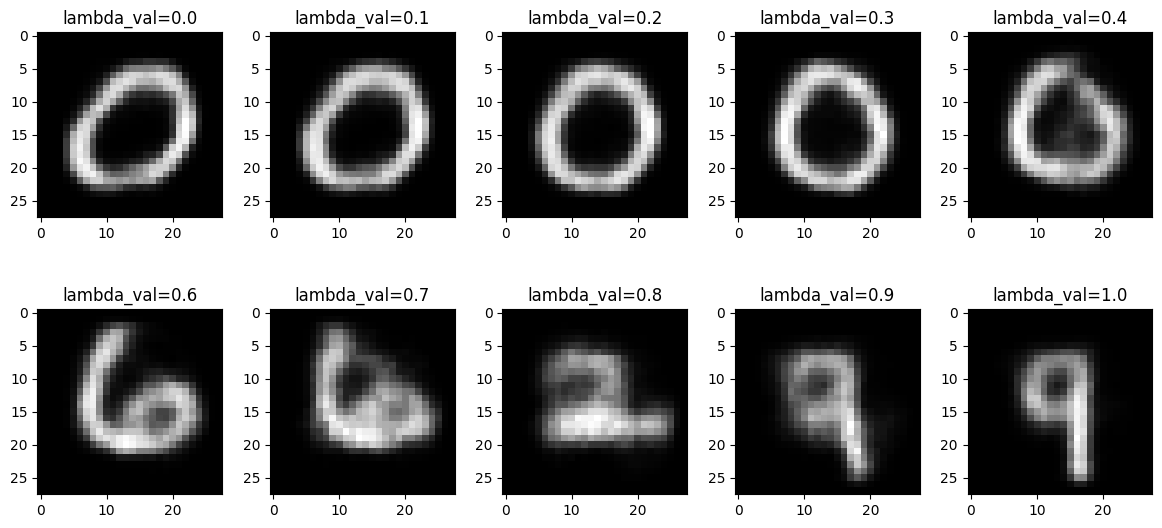

In [ ]:

vae_A.eval()

# sort part of test set by digit
digits = [[] for _ in range(10)]
for img_batch, label_batch in test_dataloader:
    for i in range(img_batch.size(0)):
        digits[label_batch[i]].append(img_batch[i:i+1])
    if sum(len(d) for d in digits) >= 1000:
        break;

# interpolation lambdas
lambda_range=np.linspace(0,1,10)

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    inter_image=interpolation(float(l), vae_A, digits[9][0], digits[0][0])
   
    inter_image = to_img(inter_image)
    image = inter_image.numpy()

    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))

plt.show() 

# Sample Latent Vector from Prior (VAE as Generator)
-------------------------------------------------

A VAE can generate new digits by drawing latent vectors from the prior distribution. Although the generated digits are not perfect, they are usually better than for a non-variational Autoencoder (compare results for the 10d VAE to the results for the autoencoder).

Similar to autoencoders, the manifold of latent vectors that decode to valid digits is sparser in higher-dimensional latent spaces. Increasing the weight of the KL-divergence term in the loss (increasing `variational_beta`) makes the manifold less sparse at the cost of a lower-quality reconstruction. A pre-trained model with `variational_beta = 10` is available at `./pretrained/vae_10d_beta10.pth`.

## prior distribution of training data

In [ ]:
# sort part of train set by digit
digits = [[] for _ in range(10)]
for img_batch, label_batch in train_dataloader:
    for i in range(img_batch.size(0)):
        digits[label_batch[i]].append(img_batch[i:i+1])
    if sum(len(d) for d in digits) >= 10000:
        break;
        
total_len=0
for i in range(10):
  total_len+= len(digits[i])

for i in range(10):
  print(i ,":", len(digits[i])/total_len*100,"%") 

0 : 9.869462025316455 %
1 : 11.431962025316455 %
2 : 9.750791139240507 %
3 : 10.007911392405063 %
4 : 9.70134493670886 %
5 : 9.394778481012658 %
6 : 9.70134493670886 %
7 : 10.344145569620252 %
8 : 9.543117088607595 %
9 : 10.255142405063292 %


In [ ]:
####### HTTP Error 404: Not Found ###########

#filename = 'vae_10d_beta10.pth'
#vae = vae_A()

#import urllib
#if not os.path.isdir('./pretrained'):
#    os.makedirs('./pretrained')
#print('downloading ...')
#urllib.request.urlretrieve ("http://geometry.cs.ucl.ac.uk/creativeai/pretrained/"+filename, "./pretrained/"+filename)
#vae.load_state_dict(torch.load('./pretrained/'+filename))
print('done')

# this is how the VAE parameters can be saved:
# torch.save(vae.state_dict(), './pretrained/my_vae.pth')

## Reconstruction of vae A

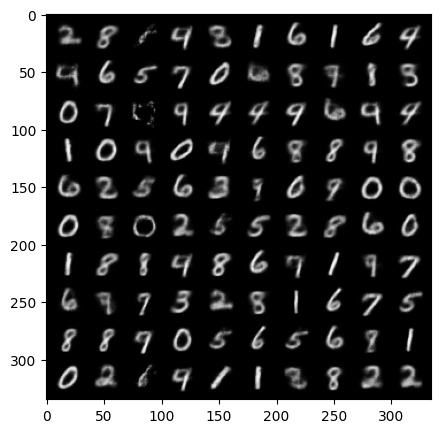

In [ ]:
vae_A.eval()

with torch.no_grad():

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, latent_dims, device=device)

    # reconstruct images from the latent vectors
    img_recon = vae_A.decode(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(5, 5))
    show_image(torchvision.utils.make_grid(img_recon.data[:100],10,5))
    plt.show()

## Sample Latent Vector from estimated Gaussian

In [ ]:
latent_mu, latent_logvar = vae_A.encode(digits[9][0])
vae_A.latent_sample(latent_mu, latent_logvar)

tensor([[-0.8910, -0.4987]], grad_fn=<AddmmBackward0>)

## Show 2D Latent Space
---------------------

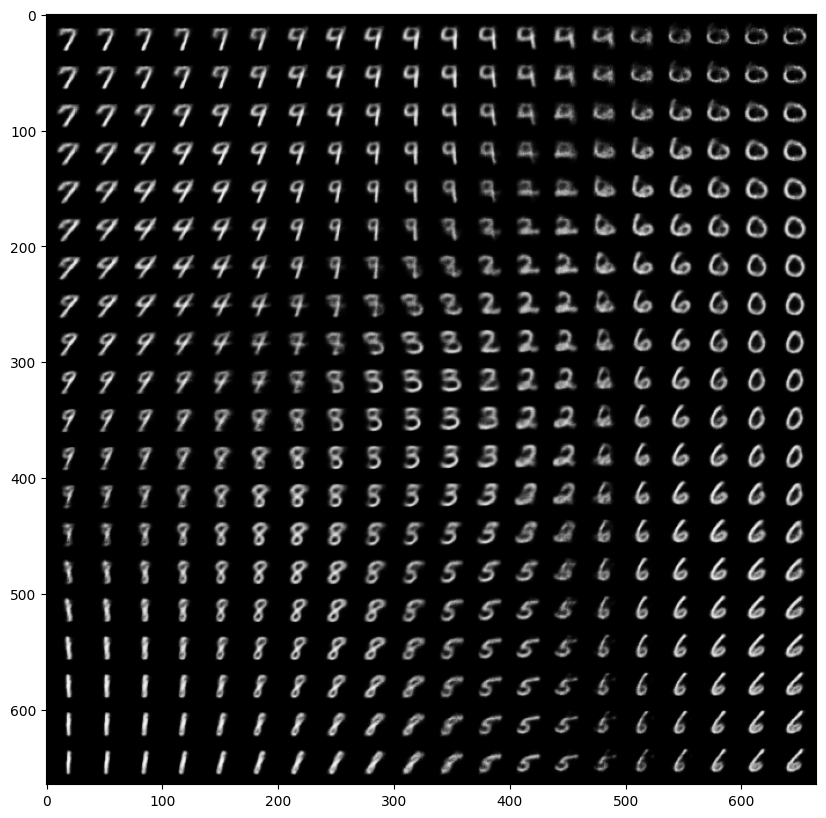

In [ ]:
# load a network that was trained with a 2d latent space
if latent_dims != 2:
    print('Please change the parameters to two latent dimensions.')
    
with torch.no_grad():
    
    # create a sample grid in 2d latent space
    latent_x = np.linspace(-1.5,1.5,20)
    latent_y = np.linspace(-1.5,1.5,20)
    latents = torch.FloatTensor(len(latent_y), len(latent_x), 2)
    for i, lx in enumerate(latent_x):
        for j, ly in enumerate(latent_y):
            latents[j, i, 0] = lx
            latents[j, i, 1] = ly
    latents = latents.view(-1, 2) # flatten grid into a batch

    # reconstruct images from the latent vectors
    latents = latents.to(device)
    image_recon = vae_A.decode(latents)
    image_recon = image_recon.cpu()

    fig, ax = plt.subplots(figsize=(10, 10))
    show_image(torchvision.utils.make_grid(image_recon.data[:400],20,5))
    plt.show()